In [1]:
from typing import TypedDict, Annotated
from IPython.display import Image, display

from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class GraphState(TypedDict):
    question: str
    count: int

In [3]:
builder = StateGraph(GraphState)

In [4]:
def my_node(state: dict, config: RunnableConfig):
    print('In node: ', config['configurable']['user_id'])
    return {'results': f'Hello, {state['input']}!'}

def my_other_node(state: dict):
    return state

In [5]:
builder.add_node('my_node', my_node)
builder.add_node('my_other_node', my_other_node)

In [6]:
def route_start(state):
    if '안녕' in state['question']:
        return 'greeting'
    else:
        return 'search'

In [7]:
builder.add_conditional_edges(
    START,
    route_start,
    {'greeting':'my_node', 'search':'my_other_node'}
)

In [8]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [9]:
workflow = StateGraph(State)

In [10]:
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

def chatbot(state: State):
    return {'messages':[llm.invoke(state['messages'])]}

workflow.add_node('chatbot', chatbot)

In [11]:
workflow.set_entry_point('chatbot')
workflow.add_edge('chatbot', END)

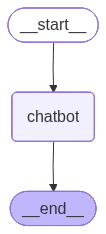

In [12]:
graph = workflow.compile()
graph

In [13]:
while True:
    user_input = input('User: ')

    if user_input.lower() in ['quit', 'exit', 'q']:
        print('다음에 뵈어요. :)')
        break

    for event in graph.stream({'messages':('user', user_input)}):
        for value in event.values():
            print('Assistant:', value['messages'][-1].content)

다음에 뵈어요. :)


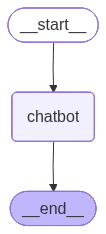

In [14]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
tool = TavilySearch(max_results=3)
tools = [tool]
tool.invoke('내일 대한민국 서울의 날씨는?')

{'query': '내일 대한민국 서울의 날씨는?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.accuweather.com/ko/kr/seoul/226081/weather-forecast/226081',
   'title': '서울특별시, 서울시, 대한민국 3일 날씨 예보 - AccuWeather',
   'content': '# 서울특별시, 서울시 54° 서울특별시, 서울시 날씨 오늘 WinterCast 지역 {stormName} 추적기 시간별 일별 레이더 MinuteCast® 월 대기질 건강 및 활동 ## 오늘  시간별   일별   레이더   MinuteCast®   월   대기질   건강 및 활동 대기질 건강에 해로움 ## 전망 ## 서울특별시 기상 레이더 오전 2시  51° 4%  오전 3시  51° 4%  오전 4시  50° 4%  오전 5시  50° 4%  오전 6시  49° 5%  오전 7시  48° 7%  오전 8시  48° 7%  오전 9시  51° 7%  오전 10시  54° 7%  오전 11시  57° 오전 중 몇 차례 소나기; 흐림 77% 수 대체로 맑음 대체로 맑음 대체로 맑음 대체로 맑음 대체로 맑음 대체로 흐림 대체로 흐림 15% 수 대기질  건강에 해로움 전 세계 아시아 대한민국 서울시 서울특별시',
   'score': 0.97482115,
   'raw_content': None},
  {'url': 'https://www.accuweather.com/ko/kr/seoul/226081/hourly-weather-forecast/226081',
   'title': '서울특별시, 서울시, 대한민국 시간별 날씨 - AccuWeather',
   'content': '# 서울특별시, 서울시 현재 위치 사용 서울특별시 서울시 44° 서울특별시, 서울시 날씨 오늘 WinterCast 지역 {stormName}